In [40]:
import os
import json
import pandas as pd
import shutil
import cv2
from matplotlib import pyplot as plt
import glob
import fileinput
import sys

# 1 DataSets

**The following datasets are used in this project:**
- nuImage: download the `Metadata` and 'Samples` files from [https://www.nuscenes.org/nuimages#download]
- pathole: download the 'pathole' dataset with Yolov7 formate: https://public.roboflow.com/object-detection/pothole/1
- Traffic Light dataset: the images and annotation can be downloaded from: https://github.com/samuelyu2002/ImVisible

## 1.1 nuImage

## Download the nuImage dataset

In [2]:
root_path = "C:/D/Data Science/EPITA/Lessons/Semester 3/Action learning/project"

In [56]:
# Path('/data/sets/nuimages').mkdir(parents=True, exist_ok=True)
image_path = os.path.join(root_path, 'data/sets/nuimages')
try:
    os.makedirs(image_path)
except FileExistsError:
    # directory already exists
    pass

In [91]:
%ls

 Volume in drive C is Windows
 Volume Serial Number is 12F5-19B0

 Directory of C:\Users\Lingfen\Workfiles\notebooks\Action_Learning\data\sets\nuimages

01/17/2023  12:43 PM    <DIR>          .
01/17/2023  12:43 PM    <DIR>          ..
01/17/2023  09:25 AM       631,346,425 nuimages-v1.0-all-metadata.tgz
01/17/2023  12:39 PM    16,391,445,635 nuimages-v1.0-all-samples.tgz
01/17/2023  11:58 AM    <DIR>          samples
01/17/2023  11:58 AM    <DIR>          sweeps
01/17/2023  12:02 PM    <DIR>          v1.0-mini
08/25/2020  01:42 PM    <DIR>          v1.0-test
08/25/2020  01:42 PM    <DIR>          v1.0-train
08/25/2020  01:42 PM    <DIR>          v1.0-val
               2 File(s) 17,022,792,060 bytes
               8 Dir(s)  232,407,621,632 bytes free


In [ ]:
# %cd "data/sets/nuimages"

# !wget https://www.nuscenes.org/data/nuimages-v1.0-all-metadata.tgz  # Download the nuImages metadata.

# !wget https://www.nuscenes.org/data/nuimages-v1.0-all-samples.tgz  # Download the nuImages samples.

# !tar zxvf nuimages-v1.0-all-metadata.tgz  # Uncompress the nuImages metadata.

!tar zxvf samples.tgz  # Uncompress the nuImages samples.

# !tar zxvf nuimages-v1.0-all-samples.tgz  # Uncompress the nuImages samples.

## Prepare the nuImage data

In [6]:
os.chdir(os.path.join(root_path, 'data/sets/nuimages'))

In [37]:
os.mkdir('nuimages_prepared')

In [44]:
with open('classes.txt', 'w') as f:
    for item in filtered_ann.sort_values(by='name').name.unique():
        f.write(item)
        f.write('\n')

In [67]:
classes = pd.read_csv('classes.csv', names = ['index', 'class_name'], index_col=False)

In [15]:
def create_anno(base_path):
    df_ann = pd.read_json(os.path.join(base_path, 'object_ann.json'))
    df_category = pd.read_json(os.path.join(base_path, 'category.json'))
    df_sample = pd.read_json(os.path.join(base_path, 'sample_data.json'))
    
    df_1 = df_ann.merge(df_category, how='left', left_on='category_token', right_on='token')
    df_joined = df_1.merge(df_sample, how='left', left_on='sample_data_token', right_on='token')
    columns = ['token', 'name', 'filename', 'width', 'height', 'bbox']
    return df_joined[columns]

In [18]:
def filter_ann(df_ann, classes_path):
    # split filename column
    df_ann[['folder_1', 'folder_2', 'file']] = df_ann['filename'].str.split('/', expand=True)
    # keep only the images in 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT' folders
    filtered_df = df_ann.loc[df_ann['folder_2'].isin(['CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT'])]
    
    # get dataframe with list of classes
    df_classes = pd.read_csv(classes_path, names = ['class_num', 'class_name'], index_col=False)
    # filter out the rows not in the classes list
    filtered_df2 = filtered_df.loc[filtered_df['name'].isin(list(df_classes['class_name']))]
    #
    df_final = filtered_df2.merge(df_classes, how='left', left_on='name', right_on='class_name')
    df_final.drop(columns=['name'])
    df_final.sort_values(by=['filename'], inplace=True)
    return df_final
    

In [37]:
def get_text_ann(df_ann, base_path):
    os.chdir(base_path)
    for index, row in df_ann.iterrows():
        src_path = row['filename']
        dst_path = os.path.join('nuimages_prepared', row['file'])
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)
            
        txt_name = 'nuimages_prepared/'+row['file'][:len(row['file'])-3]+'txt'
        
        with open(txt_name, 'a+') as f:
            width = row['width']
            height = row['height']
            x1 = row['bbox'][0]
            y1 = row['bbox'][1]
            x2 = row['bbox'][2]
            y2 = row['bbox'][3]
            center_x = (x1+x2)/(2*width)
            center_y = (y1+y2)/(2*height)
            b_width = (x2-x1)/width
            b_height = (y2-y1)/height

            line = str(row['class_num'])+' '+str(center_x)+' '+str(center_y)+' '+str(b_width)+' '+str(b_height)+'\n'
            f.write(line)

In [ ]:
# prepare folder with test images and txt annotations
test_path = os.path.join(root_path, 'data/sets/nuimages/v1.0-test')
test_joined = create_anno(test_path)
classes_path = os.path.join(root_path, 'data/sets/nuimages/classes.csv')
test_ann = filter_ann(test_joined, classes_path)
base_path = os.path.join(root_path, 'data/sets/nuimages')
get_text_ann(test_ann, base_path)

In [ ]:
# prepare folder with validation images and txt annotations
val_path = os.path.join(root_path, 'data/sets/nuimages/v1.0-val')
val_joined = create_anno(val_path)
classes_path = os.path.join(root_path, 'data/sets/nuimages/classes.csv')
val_ann = filter_ann(val_joined, classes_path)
base_path = os.path.join(root_path, 'data/sets/nuimages')
get_text_ann(val_ann, base_path)

## Check the result

In [54]:
def show_objects(img_path):
  
    # get the txt_path for the image
    txt_path = img_path[:len(img_path)-3]+'txt'
    # read txt file by line
    bboxs = []
    width = 1600
    height = 900
    with open(txt_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line_list = line.split(" ")
            x1 = int((float(line_list[1])-float(line_list[3])/2)*width)
            y1 = int((float(line_list[2])-float(line_list[4])/2)*height)
            x2 = int((float(line_list[1])+float(line_list[3])/2)*width)
            y2 = int((float(line_list[2])+float(line_list[4])/2)*height)
            bboxs.append([(x1,y1), (x2,y2)])
    
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for bbox in bboxs:
        start_point = bbox[0]
        print('start_point', start_point)
        end_point = bbox[1]
        print('end_point', end_point)
        img_rgb = cv2.rectangle(img_rgb, start_point, end_point,(255,0,0),4)
    plt.imshow(img_rgb)
    plt.show()

In [20]:
img_path = os.path.join(root_path, 'data/sets/nuimages/nuimages_prepared/n003-2018-01-03-12-03-23+0800__CAM_FRONT_LEFT__1514952466571784.jpg')

start_point (1518, 429)
end_point (1600, 512)
start_point (1488, 530)
end_point (1544, 617)
start_point (1132, 432)
end_point (1347, 524)
start_point (686, 431)
end_point (1001, 583)


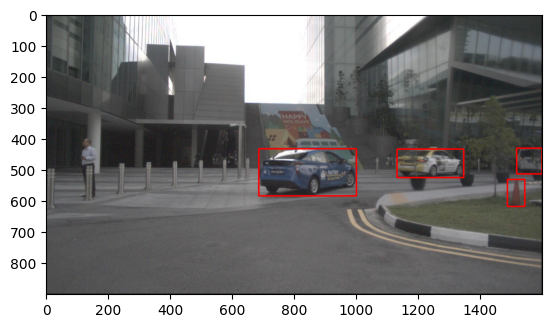

In [21]:
show_objects(img_path)

## 1.2 Pathole

## Update annotations
The dataset is already annoted with Yolov7 formate, we only need to replace the class number 0 to 20

In [48]:
def update_annotation(folder_path):
    os.chdir(folder_path)
    file_list = glob.glob('*.txt')
    for file in file_list:
        for line in fileinput.input([file], inplace=True):
            sys.stdout.write(f'2{line}')

In [50]:
folder_path = os.path.join(root_path, 'data/sets/Pothole.v1-raw.yolov7pytorch/train/labels')
update_annotation(folder_path)

In [51]:
folder_path = os.path.join(root_path, 'data/sets/Pothole.v1-raw.yolov7pytorch/test/labels')
update_annotation(folder_path)

In [52]:
folder_path = os.path.join(root_path, 'data/sets/Pothole.v1-raw.yolov7pytorch/valid/labels')
update_annotation(folder_path)

## check the result

In [ ]:
img_path = os.path.join(root_path, 'data/sets/Pothole.v1-raw.yolov7pytorch/train/img-250_jpg.rf.7632980b590d300428e1072e1f13cef1.jpg')
show_objects(img_path)

The annotations don't seem correct, the dataset will be removed for the moment

## 1.3 Traffic light 

In [ ]:
def anno_csv2txt(csv_path, image_path):
    df_anno = pd.read_csv(csv_path)
    for index, row in df_anno.iterrows():
        t
        